# Восстановление золота из руды

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Чтение файлов ###

In [2]:
data_train = pd.read_csv('gold_recovery_train_new.csv')

In [3]:
data_test = pd.read_csv('gold_recovery_test_new.csv')

In [4]:
data_full = pd.read_csv('gold_recovery_full_new.csv')

### Первичный анализ данных ###

#### Обучающая выборка ####

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant             

In [6]:
data_train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [7]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [8]:
data_train.isna().sum().sum()

4100

In [9]:
data_train.duplicated().sum()

0

Предварительный анализ данных об обучающей выборке (87 колонок с признаками, 14149 строк) показал наличие пропусков в данных (в целом до 5 %, и только в 1 признаке 'secondary_cleaner.output.tail_sol' количество пропусков более 10 %)

Полные дубликаты не выявлены. Числовые аномалии не обнаружены, однако есть данные со значением 0, в количественных признаках видны признаки с разными разбросами.  

#### Тестовая выборка ####

In [10]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
date                                          5290 non-null object
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.in

In [11]:
data_test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [12]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


In [13]:
data_test.isna().sum().sum()

90

In [14]:
data_test.duplicated().sum()

0

Предварительный анализ данных о тестовой выборке (53 колонки с признаками, 5290 строк) показал наличие пропусков в данных (меньше 1 %)

Полные дубликаты не выявлены. Числовые аномалии не обнаружены, однако есть данные со значением 0, в количественных признаках видны признаки с разными разбросами.  

#### Исходные данные ####

In [15]:
data_full.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [16]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
date                                                  19439 non-null object
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant             

In [17]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


In [18]:
data_full.isna().sum().sum()

4481

In [19]:
data_full.duplicated().sum()

0

Предварительный анализ исходных данных (87 колонок с признаками, 19439 строк) показал наличие пропусков в данных (в целом до 5 %, и только в 1 признаке 'secondary_cleaner.output.tail_sol' количество пропусков более 10 %)

Полные дубликаты не выявлены. Числовые аномалии не обнаружены, однако есть данные со значением 0, в количественных признаках видны признаки с разными разбросами.  

### Вычисления эффективности обогащения (Recovery) ###

Вычислю на обучающей выборке для признака rougher.output.recovery

Рассчитаю эффективность по формуле rec_train = 

$$\frac{C (F-T)}{F (C-T)} * 100$$

Объявлю константные переменные C, F, T

In [20]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au'] 
T = data_train['rougher.output.tail_au'] 

In [21]:
rec_train = ((C*(F-T))/(F*(C-T)))*100

In [22]:
rec_train.head(3)

0    87.107763
1    86.843261
2    86.842308
dtype: float64

In [23]:
print('Эффективность обогащения в среднем составляет:', rec_train.mean())

Эффективность обогащения в среднем составляет: 82.70450164550293


### MAE между расчётами эффективности (из п. 1.3) и значением признака 'rougher.output.recovery' ###

In [24]:
print('MAE составляет:', mean_absolute_error(data_train['rougher.output.recovery'], rec_train))

MAE составляет: 9.682896147825551e-15


MAE небольшое. Соотвественно данные в признаке 'rougher.output.recovery' указаны с достаточной точностью.   

### Анализ признаков, недоступных в тестовой выборке ###

In [25]:
missed_columns_in_test = list(set(data_train) - set(data_test))
len(missed_columns_in_test)

34

In [26]:
missed_columns_in_test

['primary_cleaner.output.tail_au',
 'rougher.calculation.au_pb_ratio',
 'final.output.tail_sol',
 'rougher.output.tail_sol',
 'rougher.output.concentrate_au',
 'final.output.tail_pb',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.recovery',
 'primary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_sol',
 'final.output.concentrate_sol',
 'secondary_cleaner.output.tail_sol',
 'rougher.output.tail_au',
 'final.output.concentrate_ag',
 'rougher.output.tail_ag',
 'final.output.tail_ag',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_sol',
 'final.output.recovery',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',

В тестовой выборке пропущено 34 признака: 8 признаков "primary_cleaner.output", 4 "secondary_cleaner.output", 4 "rougher.calculation"(это расчетные характеристики), 9 "rougher.output", 9 "final.output".

Отсутствует информация:

- о целевых признаках,

- о хвостах на всех этапах процесса, 

- о доле металлов на этапах primary_cleaner, rougher и final,

- об эффективности обогащения после флотации и на финале,

- о некоторых флотационных реагентах.

Пропущеные признаки не известны на этапе подготовки модели, значит это онлайн-метрики, которые станут известны в результате и по ходу процесса обогащения. 

Все остальные метрики можно считать офлайн-метриками, которые можно посчитать по исторческим данным (ранее уже собранным).

### Предобработка данных ###

Поменяю тип данных в колонках 'date'

В данных есть достаточно много пропусков, заменю их с помошью методов ffill и bfill.

In [27]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_test['date'] = pd.to_datetime(data_test['date'])
data_full['date'] = pd.to_datetime(data_full['date'])

In [28]:
data_train['rougher.output.recovery'].isna().sum()

0

In [29]:
data_full['rougher.output.recovery'].isna().sum()

0

In [30]:
data_train['final.output.recovery'].isna().sum()

0

In [31]:
data_full['final.output.recovery'].isna().sum()

0

Пропусков в целевых признаках нет

In [32]:
data_train = data_train.fillna(method='ffill').fillna(method='bfill')

In [33]:
data_test = data_test.fillna(method='ffill').fillna(method='bfill')

In [34]:
data_full = data_full.fillna(method='ffill').fillna(method='bfill')

In [35]:
data_train.isna().sum().sum()

0

In [36]:
data_test.isna().sum().sum()

0

In [37]:
data_full.isna().sum().sum()

0

### Вывод  ###

Прочитаны файды с данными о тестовой и обучающей выборке и об исходных данных.

Дубликаты не обнаружены.

Пропуски есть (их суммарно почти 30 %), поэтому произвела замену исходя из соседних значений (по дате). Замена произвелась корректно.

Проверена формула расчета эффективности обогащения - она работает верно.

Выявлены и проанализированы признаки, отсутствующие в тестовой выборке:

- отсутствуют целевые признаки, 

- данные о хвостах, 

- об эффективности обогащения, 

- о некоторых флотационных реагентах,

- о доле металла на некоторых этапах процесса


## Анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки ###

Проверку сделаю на основе **исходных данных**

#### Концентрация золота (Au) ####

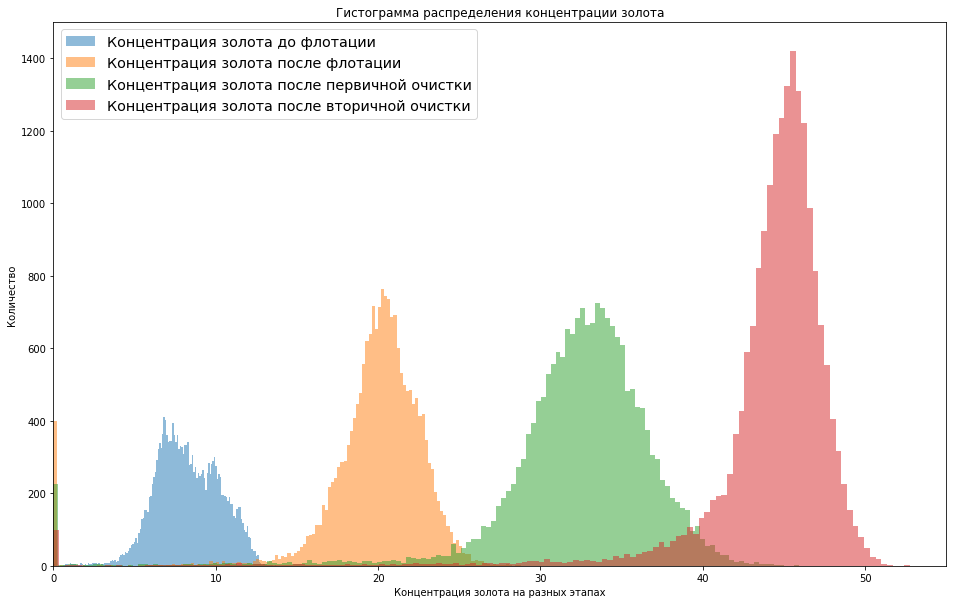

In [38]:
plt.figure(figsize=[16,10])

plt.hist(data_full['rougher.input.feed_au'], bins=150, label = 'Концентрация золота до флотации', alpha=.5)
plt.hist(data_full['rougher.output.concentrate_au'], bins=150, label = 'Концентрация золота после флотации', alpha=.5)
plt.hist(data_full['primary_cleaner.output.concentrate_au'], bins=150, label = 'Концентрация золота после первичной очистки', alpha=.5)
plt.hist(data_full['final.output.concentrate_au'], bins=150, label = 'Концентрация золота после вторичной очистки', alpha=.5)

plt.xlim([0, 55])
plt.ylim([0, 1500])

plt.xlabel("Концентрация золота на разных этапах")
plt.ylabel("Количество")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации золота")
plt.show()

In [39]:
print('Средняя концентрация золота:')
print('до флотации: {:.2f}'.format(data_full['rougher.input.feed_au'].mean()))
print('после флотации: {:.2f}'.format(data_full['rougher.output.concentrate_au'].mean()))
print('после первичной очистки: {:.2f}'.format(data_full['primary_cleaner.output.concentrate_au'].mean()))
print('после вторичной очистки: {:.2f}'.format(data_full['final.output.concentrate_au'].mean()))

Средняя концентрация золота:
до флотации: 8.27
после флотации: 19.77
после первичной очистки: 32.12
после вторичной очистки: 44.08


#### Концентрация серебра (Ag) ####

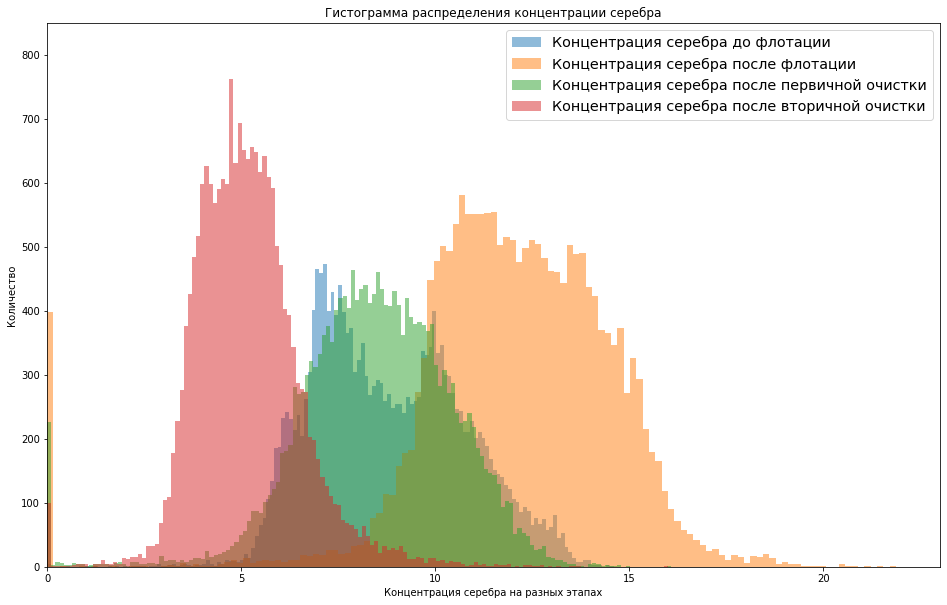

In [40]:
plt.figure(figsize=[16,10])

plt.hist(data_full['rougher.input.feed_ag'], bins=150, label = 'Концентрация серебра до флотации', alpha=.5)
plt.hist(data_full['rougher.output.concentrate_ag'], bins=150, label = 'Концентрация серебра после флотации', alpha=.5)
plt.hist(data_full['primary_cleaner.output.concentrate_ag'], bins=150, label = 'Концентрация серебра после первичной очистки', alpha=.5)
plt.hist(data_full['final.output.concentrate_ag'], bins=150, label = 'Концентрация серебра после вторичной очистки', alpha=.5)

plt.xlim([0, 23])
plt.ylim([0, 850])

plt.xlabel("Концентрация серебра на разных этапах")
plt.ylabel("Количество")

plt.legend(loc='upper right', fontsize='x-large')

plt.title("Гистограмма распределения концентрации серебра")
plt.show()

In [41]:
print('Средняя концентрация серебра:')
print('до флотации: {:.2f}'.format(data_full['rougher.input.feed_ag'].mean()))
print('после флотации: {:.2f}'.format(data_full['rougher.output.concentrate_ag'].mean()))
print('после первичной очистки: {:.2f}'.format(data_full['primary_cleaner.output.concentrate_ag'].mean()))
print('после вторичной очистки: {:.2f}'.format(data_full['final.output.concentrate_ag'].mean()))

Средняя концентрация серебра:
до флотации: 8.79
после флотации: 11.99
после первичной очистки: 8.44
после вторичной очистки: 5.17


#### Концентрация свинца (Pb) ####

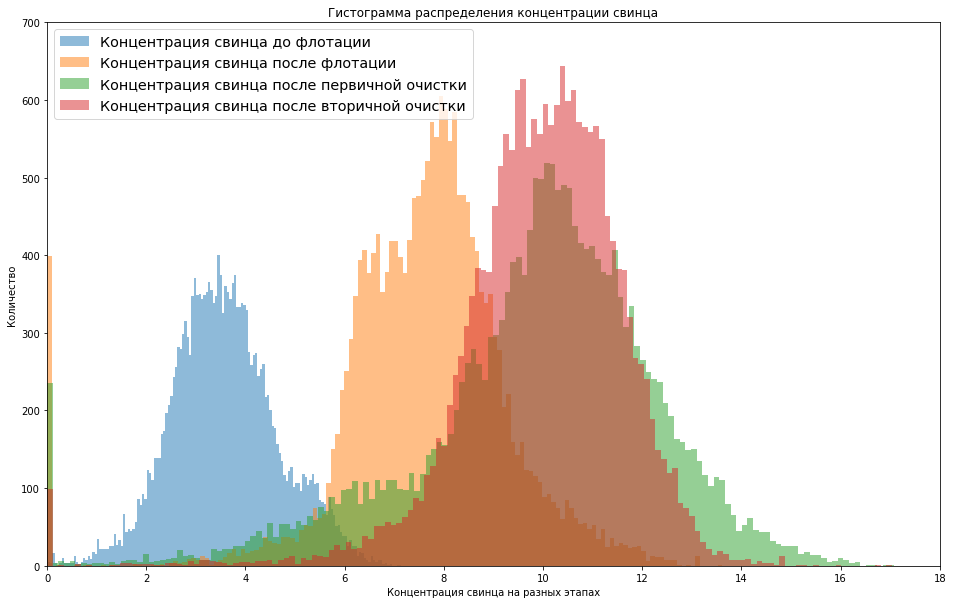

In [42]:
plt.figure(figsize=[16,10])

plt.hist(data_full['rougher.input.feed_pb'], bins=150, label = 'Концентрация свинца до флотации', alpha=.5)
plt.hist(data_full['rougher.output.concentrate_pb'], bins=150, label = 'Концентрация свинца после флотации', alpha=.5)
plt.hist(data_full['primary_cleaner.output.concentrate_pb'], bins=150, label = 'Концентрация свинца после первичной очистки', alpha=.5)
plt.hist(data_full['final.output.concentrate_pb'], bins=150, label = 'Концентрация свинца после вторичной очистки', alpha=.5)

plt.xlim([0, 18])
plt.ylim([0, 700])

plt.xlabel("Концентрация свинца на разных этапах")
plt.ylabel("Количество")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентрации свинца")
plt.show()

In [43]:
print('Средняя концентрация свинца:')
print('до флотации: {:.2f}'.format(data_full['rougher.input.feed_pb'].mean()))
print('после флотации: {:.2f}'.format(data_full['rougher.output.concentrate_pb'].mean()))
print('после первичной очистки: {:.2f}'.format(data_full['primary_cleaner.output.concentrate_pb'].mean()))
print('после вторичной очистки: {:.2f}'.format(data_full['final.output.concentrate_pb'].mean()))

Средняя концентрация свинца:
до флотации: 3.59
после флотации: 7.61
после первичной очистки: 9.81
после вторичной очистки: 9.98


С каждым этапом:
- концентрация золота увеличивается (что объяснимо, так как цель процесса - достигнуть максимальной концентрации золота), 
- концентрация серебра снижается (максимальное значение было после флотации, затем стабильное снижение),
- концентрация свинца возросла к флотации и затем усредниалсь после 2-х этапов очистки

Кроме того, после этапа флотации достаточно много нулевых значений у всех металлов. С этим разберусь позже.

### Оценка распределения размеров гранул сырья  ###

Проверю распределение на обучающей и тестовой выборках

#### До флотации ####

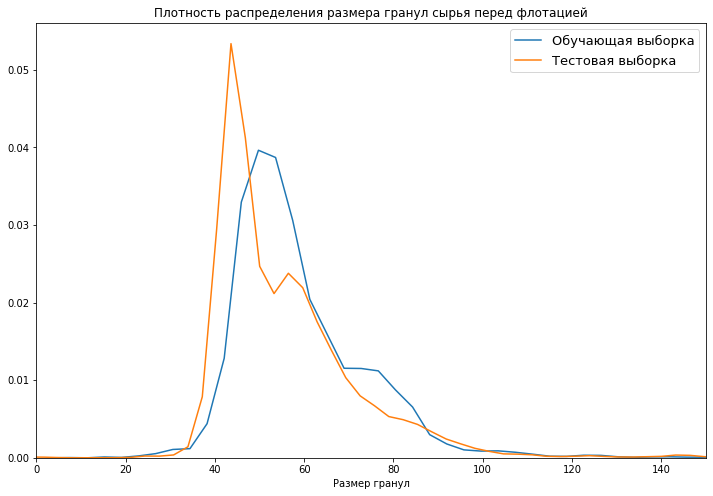

In [44]:
plt.figure(figsize=[12,8])
for frame,name in zip([data_train,data_test],
                       ["Обучающая выборка","Тестовая выборка"]):
    subset = frame["rougher.input.feed_size"]

    sns.distplot(subset, hist = False, kde = True, label = name)
plt.legend(prop={'size': 13})
plt.xlabel('Размер гранул')
plt.title("Плотность распределения размера гранул сырья перед флотацией")
plt.xlim([0, 150])
plt.show()

#### После флотации и до первичной очистки ####

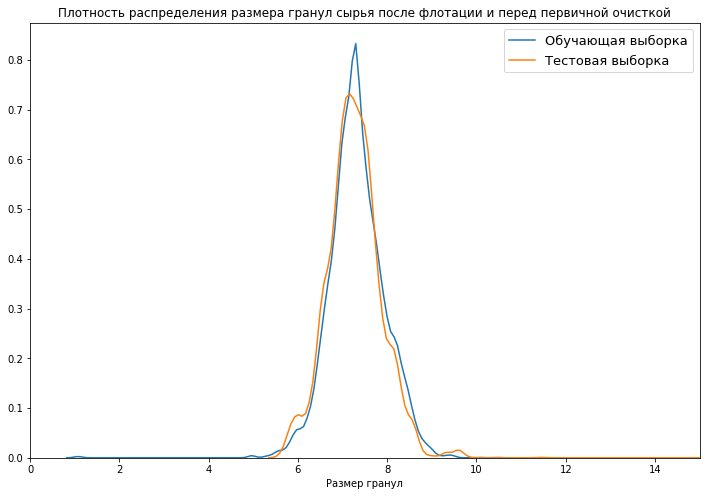

In [45]:
plt.figure(figsize=[12,8])
for frame,name in zip([data_train,data_test],
                       ["Обучающая выборка","Тестовая выборка"]):
    subset = frame["primary_cleaner.input.feed_size"]

    sns.distplot(subset, hist = False, kde = True, label = name)
plt.legend(prop={'size': 13})
plt.xlabel('Размер гранул')
plt.title("Плотность распределения размера гранул сырья после флотации и перед первичной очисткой")
plt.xlim([0, 15])
plt.show()

До флотации распеределение размера гранул в обучающей и тестовой выборках немного разное:

- в обучающей выборке пик примерно 55,

- в тестовой выборке пик около 40,

- у обоих выборок есть выбросы справа, после 115.

После флотации и перед первичной очисткой размер гранул сырья в обоих выборках визуально становится более схожим и нормальным

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах ###

#### Рассчет суммарной концентрации всех веществ на обучающей выборке ####

In [46]:
rougher_input_sum_full = (data_train['rougher.input.feed_au'] +
                         data_train['rougher.input.feed_ag'] +
                         data_train['rougher.input.feed_pb'] +
                         data_train['rougher.input.feed_sol'])

In [47]:
rougher_concentrate_sum_full = (data_train['rougher.output.concentrate_au'] + 
                               data_train['rougher.output.concentrate_ag'] + 
                               data_train['rougher.output.concentrate_pb'] + 
                               data_train['rougher.output.concentrate_sol'])

In [48]:
primary_cleaner_concentrate_sum_full = (data_train['primary_cleaner.output.concentrate_au'] +
                                       data_train['primary_cleaner.output.concentrate_ag'] +
                                       data_train['primary_cleaner.output.concentrate_pb'] +
                                       data_train['primary_cleaner.output.concentrate_sol']) 

In [49]:
final_concentrate_sum_full = (data_train['final.output.concentrate_au'] +
                             data_train['final.output.concentrate_ag'] +
                             data_train['final.output.concentrate_pb'] +
                             data_train['final.output.concentrate_sol'])

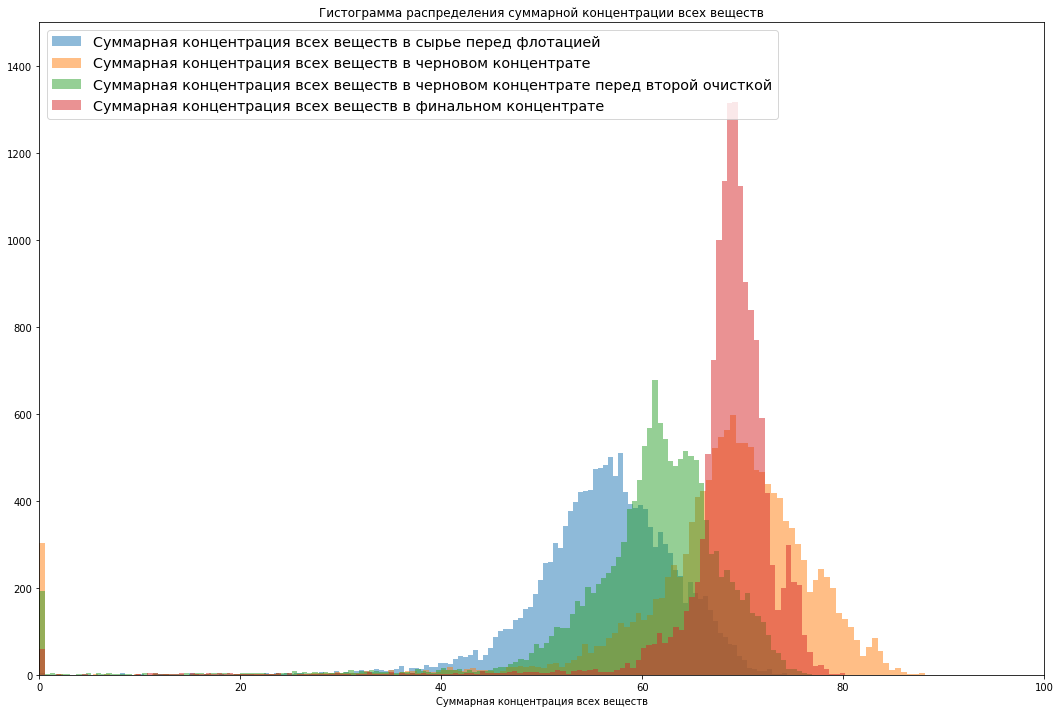

In [50]:
plt.figure(figsize=[18,12])

plt.hist(rougher_input_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в сырье перед флотацией', alpha=.5)
plt.hist(rougher_concentrate_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в черновом концентрате', alpha=.5)
plt.hist(primary_cleaner_concentrate_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в черновом концентрате перед второй очисткой', alpha=.5)
plt.hist(final_concentrate_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в финальном концентрате', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентрация всех веществ")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения суммарной концентрации всех веществ")
plt.show()

Распределение суммарной концентрации всех веществ - почти нормальное со скошенностью влево. Также есть пик значений на занчении "0" - это выбросы.

Значит в выборках есть данные со значением "0".

Перед обучением модели обработаю данные с нулевыми значениями в обучающей и тестовой выборках.

#### Обработка данных с нулевыми значениями ####

Чтобы нулевые значения (выбросы) не мешали обучению, удалю околонулевые выбросы в обучающей выборке

In [51]:
columns_concentrate_metall_train = data_train.loc[:,['rougher.output.concentrate_au', 'rougher.output.concentrate_ag',
                                                     'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
                                                     'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag',
                                                    'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
                                                    'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
                                                    'final.output.concentrate_sol']]

In [52]:
for col in columns_concentrate_metall_train:
    zeros_rows = data_train[data_train[col] < 1]
    zeros_rows_indexes = zeros_rows.index
    data_train.drop(zeros_rows_indexes, inplace=True)

Проверю, как изменилось распеределение суммарной концентрации веществ

In [53]:
rougher_input_sum_full = (data_train['rougher.input.feed_au'] +
                         data_train['rougher.input.feed_ag'] +
                         data_train['rougher.input.feed_pb'] +
                         data_train['rougher.input.feed_sol'])
rougher_concentrate_sum_full = (data_train['rougher.output.concentrate_au'] + 
                               data_train['rougher.output.concentrate_ag'] + 
                               data_train['rougher.output.concentrate_pb'] + 
                               data_train['rougher.output.concentrate_sol'])
primary_cleaner_concentrate_sum_full = (data_train['primary_cleaner.output.concentrate_au'] +
                                       data_train['primary_cleaner.output.concentrate_ag'] +
                                       data_train['primary_cleaner.output.concentrate_pb'] +
                                       data_train['primary_cleaner.output.concentrate_sol']) 
final_concentrate_sum_full = (data_train['final.output.concentrate_au'] +
                             data_train['final.output.concentrate_ag'] +
                             data_train['final.output.concentrate_pb'] +
                             data_train['final.output.concentrate_sol'])

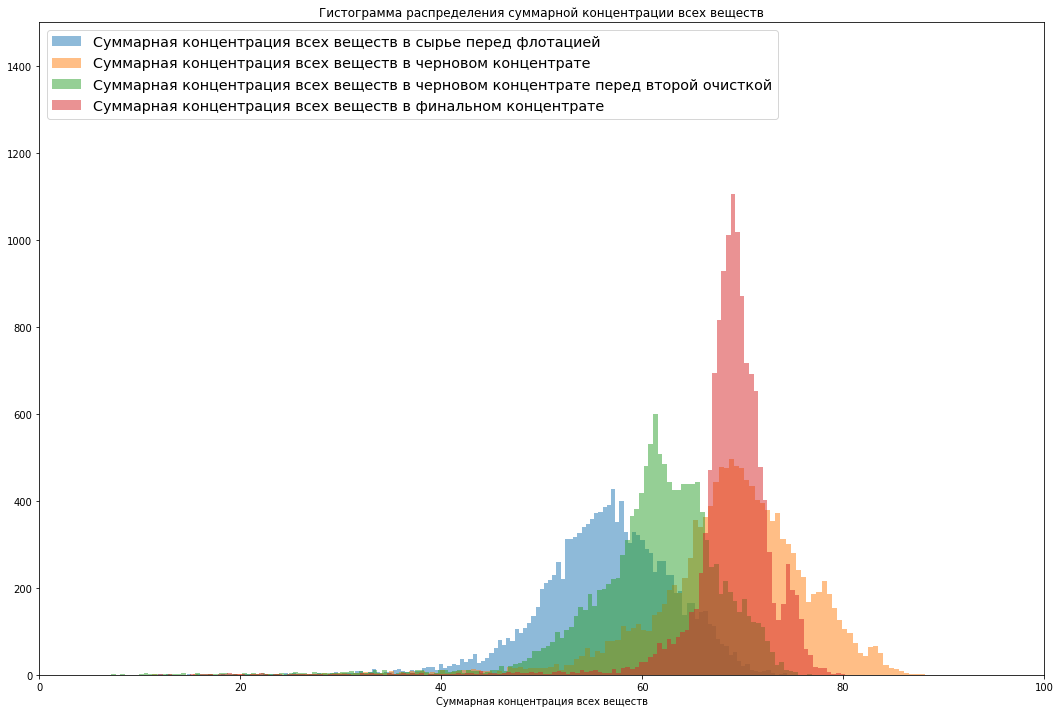

In [54]:
plt.figure(figsize=[18,12])

plt.hist(rougher_input_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в сырье перед флотацией', alpha=.5)
plt.hist(rougher_concentrate_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в черновом концентрате', alpha=.5)
plt.hist(primary_cleaner_concentrate_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в черновом концентрате перед второй очисткой', alpha=.5)
plt.hist(final_concentrate_sum_full, bins=150, label = 'Суммарная концентрация всех веществ в финальном концентрате', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 1500])

plt.xlabel("Суммарная концентрация всех веществ")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения суммарной концентрации всех веществ")
plt.show()

Данных со значениями меньше 1 удалены (в основном это данные о черновом концентрате на этапе чисток)

## Модель

### Функция для  вычисления итоговой sMAPE ###

Сначала объявлю функцию для расчета sMAPE - smape, затем функцию для расчета итоговой sMAPE - total_smape 

In [55]:
def smape(target, prediction):
    smape = 100/len(target) * np.sum(2 * np.abs(prediction - target) / (np.abs(target) + np.abs(prediction)))
    return smape
      
def total_smape(rougher, final):
    total_smape = 0.25*rougher + 0.75*final
    return total_smape

In [56]:
smape_score = make_scorer(smape,greater_is_better=False)

### Подготовка признаков для обучения моделей ###

Выделение целевых признаков и признаков для обучения

Выделю из обучающей выборки целевые признаки, остальные признаки приведу в соотвествие с тестовой выборкой

Из исходных данных добавлю целевые признаки для тестовой выборки

#### Обучающая выборка ####

Выделю 2 целевых признака (для каждого будет своя модель) - 'final.output.recovery' и 'rougher.output.recovery'.

Для обучения признаков из обучающей выборки "вычту" признаки, которые отсутствуют в тестовой выборке

In [57]:
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']
features_train = data_train.drop(missed_columns_in_test, axis=1)
features_train = features_train.drop(['date'], axis=1)

In [58]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13425 entries, 0 to 14148
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 13425 non-null float64
primary_cleaner.input.depressant              13425 non-null float64
primary_cleaner.input.feed_size               13425 non-null float64
primary_cleaner.input.xanthate                13425 non-null float64
primary_cleaner.state.floatbank8_a_air        13425 non-null float64
primary_cleaner.state.floatbank8_a_level      13425 non-null float64
primary_cleaner.state.floatbank8_b_air        13425 non-null float64
primary_cleaner.state.floatbank8_b_level      13425 non-null float64
primary_cleaner.state.floatbank8_c_air        13425 non-null float64
primary_cleaner.state.floatbank8_c_level      13425 non-null float64
primary_cleaner.state.floatbank8_d_air        13425 non-null float64
primary_cleaner.state.floatbank8_d_level      13425 non-null float64
rougher.input.feed_ag                         13425 non-null fl

#### Тестовая выборка ####

Так как в тестовой выборке нет целевых признаков, то я их возьму из исходных данных. Для этого с помощью .merge() добавлю 2 столбца 'final.output.recovery' и 'rougher.output.recovery' по совпадающим датам

In [59]:
data_test = data_test.merge(data_full[['date', 'final.output.recovery', 'rougher.output.recovery']], how='left', on='date')

In [60]:
target_test_rougher = data_test['rougher.output.recovery']
target_test_final = data_test['final.output.recovery']
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
features_test = features_test[features_train.columns]

In [61]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         5290 non-null float64
rougher.i

### Обучение моделей ###

#### Линейная регрессия (LinearRegression)  ####

с проверкой качества кросс-валидацией

**Для rougher.output.recovery**

In [62]:
model_lr_rougher = LinearRegression()

In [63]:
predictions_lr_rougher = pd.Series(cross_val_predict(model_lr_rougher, features_train, target_train_rougher, cv=5))
smape_lr_rouger = smape(target_train_rougher, predictions_lr_rougher)

In [64]:
print('sMAPE модели Линейная регрессия для признака rougher.output.recovery: {:.2f}'.format(smape_lr_rouger))

sMAPE модели Линейная регрессия для признака rougher.output.recovery: 7.85


**Для  final.output.recovery**

In [65]:
model_lr_final = LinearRegression()

In [66]:
predictions_lr_final = pd.Series(cross_val_predict(model_lr_rougher, features_train, target_train_final, cv=5))
smape_lr_final = smape(target_train_final, predictions_lr_final)

In [67]:
print('sMAPE модели Линейная регрессия (по результатам кросс-валидации) для признака final.output.recovery: {:.2f}'.format(smape_lr_final))

sMAPE модели Линейная регрессия (по результатам кросс-валидации) для признака final.output.recovery: 11.95


##### Линейная регрессия с масштабированными признаками #####
    
Проверю измениться ли sMAPE модели, если я отмасштабирую признаки 

In [68]:
scaler = StandardScaler()
scaler.fit(features_train) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [69]:
features_train_scaled = scaler.transform(features_train)

predictions_lr_rougher_scaled = pd.Series(cross_val_predict(model_lr_rougher, features_train_scaled, 
                                                            target_train_rougher, cv=5))
smape_lr_rouger_scaled = smape(target_train_rougher, predictions_lr_rougher_scaled)

predictions_lr_final_scaled = pd.Series(cross_val_predict(model_lr_rougher, features_train_scaled, 
                                                          target_train_final, cv=5))
smape_lr_final_scaled = smape(target_train_final, predictions_lr_final_scaled)

In [70]:
print('sMAPE модели Линейная регрессия (по результатам кросс-валидации, масштабированные признаки:')
print('для признака final.output.recovery: {:.2f}'.format(smape_lr_rouger_scaled))
print('для признака final.output.recovery: {:.2f}'.format(smape_lr_final_scaled))

sMAPE модели Линейная регрессия (по результатам кросс-валидации, масштабированные признаки:
для признака final.output.recovery: 7.85
для признака final.output.recovery: 11.95


Для признака  rougher.output.recovery sMAPE модели на  44% ниже, чем для признака   final.output.recovery
Масштабирование данных не повляило на результат 

#### Случайный лес (RandomForest) и Решающее дерево (DecisionTree)  ####

с проверкой качества кросс-валидацией, лучшие параметры подберу с помощью GridSearchCV (уже включает кросс-валидацию) и pipeline.

Учитывая, что при начальном анализе данных в признаках был виден значительный разброс данных (они все численные), то будет необходимо еще масштабирование признаков с помощью StandardScaler

**Инициализация pipeline**

In [71]:
model_rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=12345))
model_dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))

**Инициализация параметров для GridSearch**

In [72]:
parameters_rf = {'randomforestregressor__n_estimators':[5,155, 5],
             'randomforestregressor__max_depth':[1,21,2],
              'randomforestregressor__max_leaf_nodes':[10,55, 5]}
parameters_dt = {'decisiontreeregressor__max_depth':[1,21,2]}

In [73]:
grid_rougher_rf = GridSearchCV(model_rf,param_grid=parameters_rf, scoring=smape_score, cv=5)
grid_final_rf = GridSearchCV(model_rf,param_grid=parameters_rf, scoring=smape_score, cv=5)

In [74]:
grid_rougher_dt = GridSearchCV(model_dt,param_grid=parameters_dt, scoring=smape_score)
grid_final_dt = GridSearchCV(model_dt,param_grid = parameters_dt, scoring=smape_score)

**Непосредственно обучение моделей для выявления лучших параметров**

In [75]:
grid_rougher_rf.fit(features_train, target_train_rougher)
grid_final_rf.fit(features_train, target_train_final)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=

In [76]:
grid_rougher_dt.fit(features_train, target_train_rougher)
grid_final_dt.fit(features_train, target_train_final)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_sam

In [77]:
print('Лучшая модель Случайный лес для признака rougher.output.recovery:')
print(grid_rougher_rf.best_estimator_)

Лучшая модель Случайный лес для признака rougher.output.recovery:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=21, max_features='auto',
                                       max_leaf_nodes=10,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=155, n_jobs=None,
                                       oob_score=False, random_state=12345,
                                       verbose=0, warm_start=False))],
         verbose=False)


In [78]:
print('Лучшая модель Случайный лес для признака final.output.recovery:')
print(grid_final_rf.best_estimator_)

Лучшая модель Случайный лес для признака final.output.recovery:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=21, max_features='auto',
                                       max_leaf_nodes=55,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=155, n_jobs=None,
                                       oob_score=False, random_state=12345,
                                       verbose=0, warm_start=False))],
         verbose=False)


In [79]:
grid_rougher_rf.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__max_leaf_nodes': 10,
 'randomforestregressor__n_estimators': 155}

In [80]:
grid_final_rf.best_params_

{'randomforestregressor__max_depth': 21,
 'randomforestregressor__max_leaf_nodes': 55,
 'randomforestregressor__n_estimators': 155}

Для модели Случайный лес лучшие параметры:

- для rougher.output.recovery: 155 деревьев с глубиной 21 и 10 листьями

- для final.output.recovery: 155 деревьев с глубиной 21 и 55 листьями

In [81]:
print('Лучшая модель Решающее дерево для признака rougher.output.recovery::')
print(grid_rougher_dt.best_estimator_)

Лучшая модель Решающее дерево для признака rougher.output.recovery::
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(criterion='mse', max_depth=2,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=12345,
                                       splitter='best'))],
         verbose=False)


In [82]:
print('Лучшая модель Решающее дерево для признака final.output.recovery:')
print(grid_final_dt.best_estimator_)

Лучшая модель Решающее дерево для признака final.output.recovery:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(criterion='mse', max_depth=1,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort=False, random_state=12345,
                                       splitter='best'))],
         verbose=False)


In [83]:
grid_rougher_dt.best_params_

{'decisiontreeregressor__max_depth': 2}

In [84]:
grid_final_dt.best_params_

{'decisiontreeregressor__max_depth': 1}

Для модели Решающее дерево лучшие параметры:

- для rougher.output.recovery: глубина дерева 2

- для final.output.recovery: глубина дерева 1

**Показатели sMAPE для Случайного леса и решающего дерева**

In [85]:
best_score_rf_rouger = abs(grid_rougher_rf.best_score_)
best_score_rf_final = abs(grid_final_rf.best_score_)
best_score_dt_rouger = abs(grid_rougher_dt.best_score_)
best_score_dt_final = abs(grid_final_dt.best_score_)

In [86]:
print('Лучший sMAPE для признака rougher.output.recovery:')
print('модель Случайное лес {:.2f}'.format(best_score_rf_rouger), ', модель Решающее дерево {:.2f}'.format(best_score_dt_rouger))

Лучший sMAPE для признака rougher.output.recovery:
модель Случайное лес 6.53 , модель Решающее дерево 7.98


In [87]:
print('Лучший sMAPE для признака final.output.recovery:')
print('модель Случайное лес {:.2f}'.format(best_score_rf_final), ', модель Решающее дерево {:.2f}'.format(best_score_dt_final))

Лучший sMAPE для признака final.output.recovery:
модель Случайное лес 8.85 , модель Решающее дерево 9.99


#### Lasso Regression ####

In [94]:
scaler = StandardScaler()
scaler.fit(features_train) 
model_lasso_rouger = Lasso(alpha=0.1)
predictions_lasso_rougher = pd.Series(cross_val_predict(model_lasso_rouger, features_train, target_train_rougher, cv=5))
smape_lasso_rouger = smape(target_train_rougher, predictions_lasso_rougher)

In [95]:
model_lasso_final = Lasso(alpha=0.1)
predictions_lasso_final = pd.Series(cross_val_predict(model_lasso_final, features_train, target_train_final, cv=5))
smape_lasso_final = smape(target_train_rougher, predictions_lasso_final)

/Users/kate/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2798.790132529335, tolerance: 93.21502496730463
  positive)


In [96]:
print('Лучший sMAPE для признака rougher.output.recovery:')
print('модель Лассо {:.2f}'.format(smape_lasso_rouger))

Лучший sMAPE для признака rougher.output.recovery:
модель Лассо 7.43


In [97]:
print('Лучший sMAPE для признака final.output.recovery:')
print('модель Лассо {:.2f}'.format(smape_lasso_final))

Лучший sMAPE для признака final.output.recovery:
модель Лассо 22.47


#### Ridge Regression #### 

In [98]:
scaler = StandardScaler()
scaler.fit(features_train) 
model_ridge_rouger = Ridge(alpha=0.1)
predictions_ridge_rougher = pd.Series(cross_val_predict(model_ridge_rouger, features_train, target_train_rougher, cv=5))
smape_ridge_rouger = smape(target_train_rougher, predictions_ridge_rougher)

In [99]:
model_ridge_final = Ridge(alpha = 0.1)
predictions_ridge_final = pd.Series(cross_val_predict(model_ridge_final, features_train, target_train_final, cv=5))
smape_ridge_final = smape(target_train_final, predictions_ridge_final)

In [123]:
print('Лучший sMAPE для признака rougher.output.recovery:')
print('модель Ridge {:.2f}'.format(smape_ridge_rouger))

Лучший sMAPE для признака rougher.output.recovery:
модель Ridge 7.85


In [124]:
print('Лучший sMAPE для признака final.output.recovery:')
print('модель Ridge {:.2f}'.format(smape_ridge_final))

Лучший sMAPE для признака final.output.recovery:
модель Ridge 11.95


### Итоговый sMAPE для обученных моделей ###

In [102]:
total_smape_lr = total_smape(smape_lr_rouger, smape_lr_final)

In [103]:
print('Итоговое sMAPE для модели Линейная регрессия: {:.2f}'.format(total_smape_lr))

Итоговое sMAPE для модели Линейная регрессия: 10.92


In [104]:
total_smape_rf = total_smape(best_score_rf_rouger, best_score_rf_final)

In [105]:
print('Итоговое sMAPE для модели Случайное лес: {:.2f}'.format(total_smape_rf))

Итоговое sMAPE для модели Случайное лес: 8.27


In [106]:
total_smape_dt = total_smape(best_score_dt_rouger, best_score_dt_final)

In [107]:
print('Итоговое sMAPE для модели Решающее дерево: {:.2f}'.format(total_smape_dt))

Итоговое sMAPE для модели Решающее дерево: 9.49


In [108]:
total_smape_lasso = total_smape(smape_lasso_rouger, smape_lasso_final)

In [109]:
print('Итоговое sMAPE для модели Лассо: {:.2f}'.format(total_smape_lasso))

Итоговое sMAPE для модели Лассо: 18.71


In [110]:
total_smape_ridge = total_smape(smape_ridge_rouger, smape_ridge_final)

In [122]:
print('Итоговое sMAPE для модели Ridge: {:.2f}'.format(total_smape_ridge))

Итоговое sMAPE для модели Ridge: 10.92


Если смотреть итоговое sMAPE, то меньший показатель у модели **Случайного дерева**.
    
Если смотреть по каждому целевому признаку, то опять же Случайный лес выйгрывает:

- у rougher.output.recovery - 6.54, 
    
- у final.output.recovery - 8.95.
    
Самый высокий показатель:
    
- итогового sMAPE у модели Lasso (18.71), 
    
- для rougher.output.recovery у Решающего дерева (9.99),
    
- для final.output.recovery у Lasso (22.47)

#### Выбор лучшей модели и ее проверка на тестовой выборке ####

На обучающей выборке лучший итоговый sMAPE (наименьшая ошибка) у модели Случайный лес. 

Подсчитаю итоговое sMape на тестовой выборке. 

In [112]:
rf_rougher_test = grid_rougher_rf.predict(features_test)
rf_final_test = grid_final_rf.predict(features_test)

Выведу отдельно sMAPE по каждому целевому признаку

In [113]:
smape_rf_test_rougher = smape(target_test_rougher, rf_rougher_test)

In [114]:
smape_rf_test_final = smape(target_test_final, rf_final_test)

In [115]:
total_smape_rf_test = total_smape(smape_rf_test_rougher,smape_rf_test_final)

In [116]:
print('Для модели Случайное лес на тестовой выборке:')
print('sMAPE для признака rougher.output.recovery: {:.2f}'.format(smape_rf_test_rougher))
print('sMAPE для признака final.output.recovery: {:.2f}'.format(smape_rf_test_final))
print('Итоговое sMAPE: {:.2f}'.format(total_smape_rf_test))

Для модели Случайное лес на тестовой выборке:
sMAPE для признака rougher.output.recovery: 7.99
sMAPE для признака final.output.recovery: 9.79
Итоговое sMAPE: 9.34


Затем сравню с **константной моделью** (чтобы проверить на адекватность). Использую DummyRegressor со стратегией median, обучу на обучающей выборке. Посчитаю sMAPE для каждого целевого признака и итоговое sMAPE    

In [117]:
model_dummy_rougher = DummyRegressor(strategy = 'median')
model_dummy_final = DummyRegressor(strategy = 'median')
model_dummy_rougher.fit(features_train, target_train_rougher)
model_dummy_final.fit(features_train, target_train_final)

DummyRegressor(constant=None, quantile=None, strategy='median')

In [118]:
dummy_rougher = model_dummy_rougher.predict(features_test)
dummy_final = model_dummy_final.predict(features_test)

In [119]:
smape_rf_dummy_rougher = smape(target_test_rougher, dummy_rougher)
smape_rf_dummy_final = smape(target_test_final, dummy_final)

In [120]:
total_smape_dummy = total_smape(smape_rf_dummy_rougher, smape_rf_dummy_final)

In [121]:
print('Для dummy-модели на тестовой выборке:')
print('sMAPE для признака rougher.output.recovery: {:.2f}'.format(smape_rf_dummy_rougher))
print('sMAPE для признака final.output.recovery: {:.2f}'.format(smape_rf_dummy_final))
print('Итоговое sMAPE: {:.2f}'.format(total_smape_dummy))

Для dummy-модели на тестовой выборке:
sMAPE для признака rougher.output.recovery: 8.50
sMAPE для признака final.output.recovery: 9.73
Итоговое sMAPE: 9.42


**Вывод**

При проверке на адекватность модель Случайное дерево показала себя рабочей:
    
- итоговое sMAPE у dummy-модели выше на 4.9 % по сравнению с тестовой выборкой
    
- у rougher.output.recovery  sMAPE у dummy-модели на 6.65% выше, чем в тестовой выборке
    
- у final.output.recovery sMAPE у dummy-модели на 4.62% выше, чем в тестовой выборке


## Общий вывод ##

- Во время работы над проектом были проанализированы "сырые" данные о процессе золотодобычи: иходные данные, обучающая выборка и тестовая выборка.

- Данные были проверены на наличие пропусков, полных дубликатов. Пропуски были заменены на соседние по времени данные (это допускалось заданием). Также было удалено 80 % данных выбросов (со значением 0).

- В тестовой выборке не хватало 34 признаков (в том числе целевых). Для обучения моделей целевые признаки для тестовой выборки были извлечены из исходных данных (по датам).

- Проанализированы данные о концентрации веществ на разных этапах: концентрация золота увеличивалась, концентрация серебра в финальном концентрате снизилась, концентрат свинца после 2-х очисток практически не менялся.

- Проанализированы размеры гранул сырья на обучающей и тестовой выборках: распределение практически одинаковое и после флотации оно стало практически нормальным.

- Были обучены 3 модели для прогнозирования 2-х параметров (эффективность обогащения чернового концентрата и эффективность обогащения финального концентрата): линейная регрессия, случайный лес и решающее дерево. Для последних двух моеделй были подобраны параметры с помощью GridSearchCV.

- Лучший показатель был у модели Случайный лес.

- Модель была проверена на тестовой выборке и результаты я сравнила с константной моделью. 

Я могу рекомендовать для внедрения модель **Случайное дерево** со следующими  параметрами: 
- для rougher.output.recovery: 155 деревьев с глубиной 21 и 10 листьями

- для final.output.recovery: 155 деревьев с глубиной 21 и 55 листьями 
    
Хотя безусловно модель можно настроить еще тоньше для получения меньшего количества ошибок 